<a href="https://colab.research.google.com/github/xian51/AI-models/blob/main/XIAN_ZHU_MIS780A2PartC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIS780 Advanced AI For Business - Assignment 2 - T2 2021

## Part C:  Deep Learning for Time Series Data

**Student Name:** _enter your full name here_

**Student ID:** _enter your student ID here_

*Markdown formats: All tables and images will be aligned to the left. (Do not remove this code)*

In [ ]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Prediction](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

Provide code to load all required Python libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from tensorflow.keras.models import load_model

Provide code to define any common functions.

In [ ]:
def batch_generator(batch_size, sequence_length):
    while True:
        # Allocate a new array for the batch of input-events.
        x_shape = (batch_size, sequence_length, num_x_events)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-events.
        y_shape = (batch_size, sequence_length, num_y_events)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [ ]:
# The shape of both input tensors are: [batch_size, sequence_length, num_y_events]
def loss_mse_warmup(y_true, y_pred):
    # Ignore the "warmup" parts of the sequences
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    mse = mean(square(y_true_slice - y_pred_slice))   
    return mse

In [ ]:
# Initiates collections of model performance
def start_hist():
    return {}

# Adds more performance indicators to history
def collect_hist(accum_hist, next_hist):
    # Get all keys
    keys = list(next_hist.keys())
    for k in keys:
        if k in accum_hist:
            accum_hist[k].extend(next_hist[k])
        else:
            accum_hist[k] = next_hist[k]
    return accum_hist

In [ ]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

*Load data from file and carry out necessary preprocessing.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stock = pd.read_csv('/content/drive/MyDrive/PartC-Stocks.csv',index_col='Date',parse_dates=True)
stock.head

<bound method NDFrame.head of               Day        HPQ        GOOGL  ...        ADBE         AMZN        AAPL
Date                                       ...                                     
2010-01-04  14612  23.819256   313.688690  ...   37.090000   133.899994   30.572857
2010-01-05  14613  23.919165   312.307312  ...   37.700001   134.690002   30.625713
2010-01-06  14614  23.696640   304.434448  ...   37.619999   132.250000   30.138571
2010-01-07  14615  23.705723   297.347351  ...   36.889999   130.000000   30.082857
2010-01-08  14616  23.882833   301.311310  ...   36.689999   133.520004   30.282858
...           ...        ...          ...  ...         ...          ...         ...
2019-12-24  18253  20.590000  1344.430054  ...  329.640015  1789.209961  284.269989
2019-12-26  18255  20.690001  1362.469971  ...  331.200012  1868.770020  289.910004
2019-12-27  18256  20.530001  1354.640015  ...  330.790009  1869.800049  289.799988
2019-12-30  18259  20.490000  1339.709961  ...

Check that we do not have very large gaps in time series. 

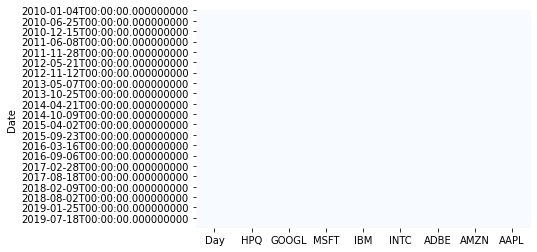

In [ ]:
sns.heatmap(stock.isnull(), cmap="Blues", cbar=False)

Check the missing values in the dataset.

In [ ]:
print('Records:\t', len(stock))
missing = stock.isnull().sum()
print(missing.sort_values(ascending=False))

Records:	 2516
AAPL     0
AMZN     0
ADBE     0
INTC     0
IBM      0
MSFT     0
GOOGL    0
HPQ      0
Day      0
dtype: int64


The selected predictors are date,and all stocks, column 'day' is not a time-series data and it is not useful for prediction.

In [ ]:
stock=stock.drop(['Day'],axis=1)

Plot the time series data of the 8 stocks.

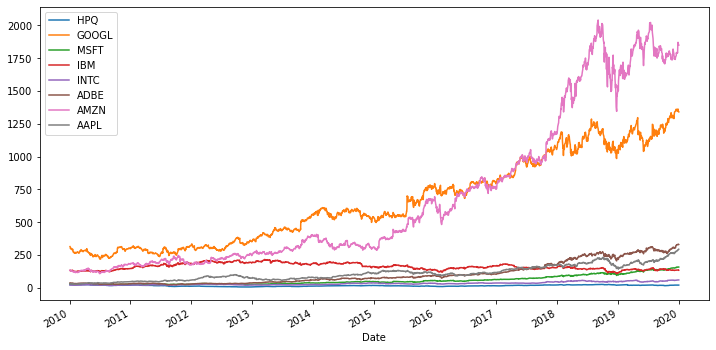

In [ ]:
stock.plot(figsize=(12,6))

*Split the data (e.g 0.7/0.3) and prepare the data for training and testing. Note that we will try to make prediction two days ahead (hint: shift the targeted variables two days backward to use as label). Clear indicates which variables are used as predictors in your code and explanation.*

In [ ]:
#define our intested stock is AAPL
target_meas = stock['AAPL']
horizon = 2
#shift the targeted variables two days backward 
df_targets = target_meas.shift(-horizon)

In [ ]:
target_meas

Date
2010-01-04     30.572857
2010-01-05     30.625713
2010-01-06     30.138571
2010-01-07     30.082857
2010-01-08     30.282858
                 ...    
2019-12-24    284.269989
2019-12-26    289.910004
2019-12-27    289.799988
2019-12-30    291.519989
2019-12-31    293.649994
Name: AAPL, Length: 2516, dtype: float64

The output clearly shows that data is shifted 2 day backwards.

In [ ]:
df_targets

Date
2010-01-04     30.138571
2010-01-05     30.082857
2010-01-06     30.282858
2010-01-07     30.015715
2010-01-08     29.674286
                 ...    
2019-12-24    289.799988
2019-12-26    291.519989
2019-12-27    293.649994
2019-12-30           NaN
2019-12-31           NaN
Name: AAPL, Length: 2516, dtype: float64

In [ ]:
# Correct predictors x and targets/labels y for the horizon shift
x_data = stock.values[0:-horizon]
y_data = df_targets.values[:-horizon]

In [ ]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

Split the data (0.7/0.3) 

In [ ]:
# Calculate training and testing partition sizes
num_data = len(x_data)
train_split = 0.7
num_train = int(train_split * num_data)
num_test = num_data - num_train


print("Original x shape:", x_data.shape, ", New x shape:", x_train.shape, x_test.shape)
print("Original y shape:", y_data.shape, ", New y shape:", y_train.shape, y_test.shape)

Original x shape: (2514, 8) , New x shape: (1759, 8) (755, 8)
Original y shape: (2514,) , New y shape: (1759,) (755,)


Normalize all variables used as predictors

In [ ]:
print("Before train x scaling - Min:", np.min(x_train), ", Max:", np.max(x_train))
print("Before test x scaling - Min:", np.min(x_test), ", Max:", np.max(x_test))
x_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
x_train_scaled = x_scaler.fit_transform(x_train).clip(0, 1)
x_test_scaled = x_scaler.transform(x_test).clip(0, 1)
print("After train x scaling - Min:", np.min(x_train_scaled), ", Max:", np.max(x_train_scaled))
print("After test x scaling - Min:", np.min(x_test_scaled), ", Max:", np.max(x_test_scaled))

Before train x scaling - Min: 5.317893028259277 , Max: 844.3599853515625
Before test x scaling - Min: 14.579999923706055 , Max: 2039.510009765625
After train x scaling - Min: 0.0 , Max: 1.0
After test x scaling - Min: 0.0 , Max: 1.0


In [ ]:
y_data = np.reshape(y_data, (-1, 1))

In [ ]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]


In [ ]:
print("Before train y scaling - Min:", np.min(y_train), ", Max:", np.max(y_train))
print("Before test y scaling - Min:", np.min(y_test), ", Max:", np.max(y_test))
# y_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
y_scaler = x_scaler
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print("After train y scaling - Min:", np.min(y_train_scaled), ", Max:", np.max(y_train_scaled))
print("After test y scaling - Min:", np.min(y_test_scaled), ", Max:", np.max(y_test_scaled))

Before train y scaling - Min: 27.43571472167969 , Max: 133.0
Before test y scaling - Min: 115.81999969482422 , Max: 293.6499938964844
After train y scaling - Min: 0.0 , Max: 1.0
After test y scaling - Min: 0.8372555617661721 , Max: 2.521821451951582


In [ ]:
#Process 30 sequences before updating the model.
batch_size = 20
#The length of each time series sequences/input dimenions.
sequence_length = 50

In [ ]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [ ]:
num_x_events = x_data.shape[1]
num_y_events = y_data.shape[1]

In [ ]:
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(20, 50, 8)
(20, 50, 1)


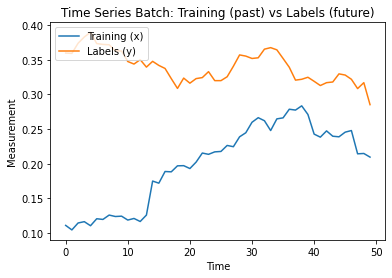

In [ ]:
batch = 0  # Some sequence in the batch
event = 0  # Some event from input-events
x_seq = x_batch[batch, :, event]
y_seq = y_batch[batch, :, event]
plt.plot(x_seq)
plt.plot(y_seq)
plt.title('Time Series Batch: Training (past) vs Labels (future)')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['Training (x)', 'Labels (y)'], loc='upper left')

<a id = "cell_model"></a>
## 3. Model Construction

In [ ]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [ ]:
epochs = 100
steps_per_epoch = 60
warmup_steps = 7 # For custom loss function

In [ ]:
#define model
def rnn_model(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=512,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='relu'))
    model.summary()
    return(model)

In [ ]:
path_checkpoint = './gru_checkpoints/'

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
        monitor='val_loss',
        verbose=1,
        save_weights_only=True,
        save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
        patience=10, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./gru_logs/',
        histogram_freq=0,
        write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
        factor=0.3,
        min_lr=1e-4,
        patience=5,
        min_delta = 1e-3,
        verbose=1)

keras_callbacks = [
        callback_early_stopping,
        #callback_tensorboard,
        callback_reduce_lr,
        callback_checkpoint
]

In [ ]:
opt_nadam = Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)
rnn_hist = start_hist()

model = rnn_model(num_x_events, num_y_events)
model.compile(loss=loss_mse_warmup, optimizer=opt_nadam, metrics=[metrics.mae])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         801792    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 512)         2048      
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 804,353
Trainable params: 803,329
Non-trainable params: 1,024
_________________________________________________________________


<a id = "cell_execution"></a>
## 4. Model Execution

In [ ]:
%%time
perform_indics = model.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data,
        callbacks=keras_callbacks,
        verbose=2
        )

# Add performance history
rnn_hist = collect_hist(rnn_hist, perform_indics.history)

Epoch 1/100
60/60 - 17s - loss: 0.3161 - mean_absolute_error: 0.3652 - val_loss: 2.2806 - val_mean_absolute_error: 1.4695

Epoch 00001: val_loss improved from inf to 2.28063, saving model to ./gru_checkpoints/
Epoch 2/100
60/60 - 13s - loss: 0.2148 - mean_absolute_error: 0.3728 - val_loss: 2.2806 - val_mean_absolute_error: 1.4695

Epoch 00002: val_loss did not improve from 2.28063
Epoch 3/100
60/60 - 13s - loss: 0.1418 - mean_absolute_error: 0.3040 - val_loss: 1.3882 - val_mean_absolute_error: 1.1264

Epoch 00003: val_loss improved from 2.28063 to 1.38817, saving model to ./gru_checkpoints/
Epoch 4/100
60/60 - 13s - loss: 0.0749 - mean_absolute_error: 0.2355 - val_loss: 0.9184 - val_mean_absolute_error: 0.8968

Epoch 00004: val_loss improved from 1.38817 to 0.91841, saving model to ./gru_checkpoints/
Epoch 5/100
60/60 - 13s - loss: 0.0546 - mean_absolute_error: 0.2014 - val_loss: 1.2047 - val_mean_absolute_error: 1.0415

Epoch 00005: val_loss did not improve from 0.91841
Epoch 6/100
60

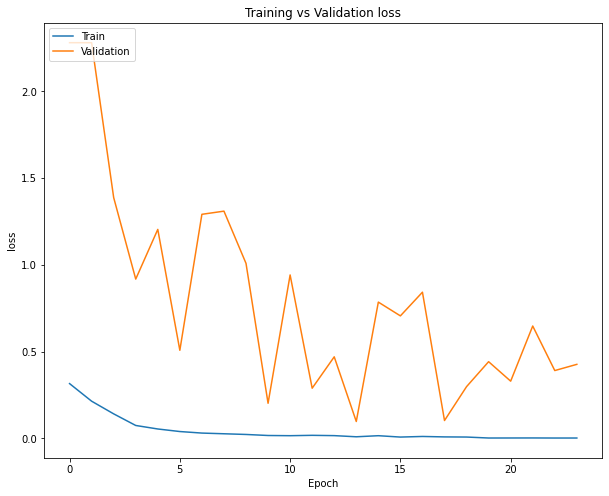

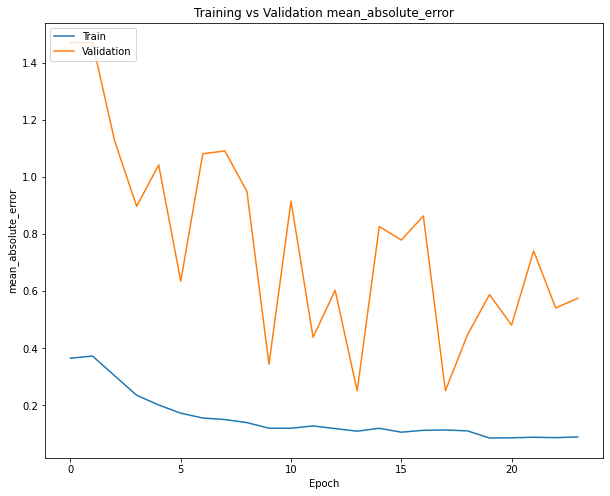

In [ ]:
plot_hist(rnn_hist, xsize=10, ysize=8)

As shown in history plot, there are significant difference between training and test for both 'loss' and 'MAE'.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Training performance

In [ ]:
result = model.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                        y=np.expand_dims(y_train_scaled, axis=0))
# We have several metrics so we want to show their names
print()
for res, metric in zip(result, model.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 787ms/step - loss: 0.0538 - mean_absolute_error: 0.1862

loss: 0.05377
mean_absolute_error: 0.18616


Test performance

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
# We have several metrics so we want to show their names
print()
for res, metric in zip(result, model.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 0s 186ms/step - loss: 0.0978 - mean_absolute_error: 0.2510

loss: 0.09780
mean_absolute_error: 0.25095


<a id = "cell_report"></a>
## 5. Prediction

Generate prediction: the predicted and true output time series of the AAPL price

In [ ]:
# Plot the predicted and true output-events.

def plot_comparison(start_idx, length=100, train=True, xlim=None, ylim=None):
    """
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-events for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-events.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-event.
    for event in range(len(target_meas)):
        # Get the output-event predicted by the model.
        event_pred = y_pred_rescaled[:, event]
        
        # Get the true output-event from the data-set.
        event_true = y_true[:, event]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two events.
        plt.plot(event_true, label='true')
        plt.plot(event_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        if (xlim): plt.xlim(xlim)
        if (ylim): plt.ylim(ylim)
        plt.ylabel(target_meas[event])
        plt.legend()
        plt.show()

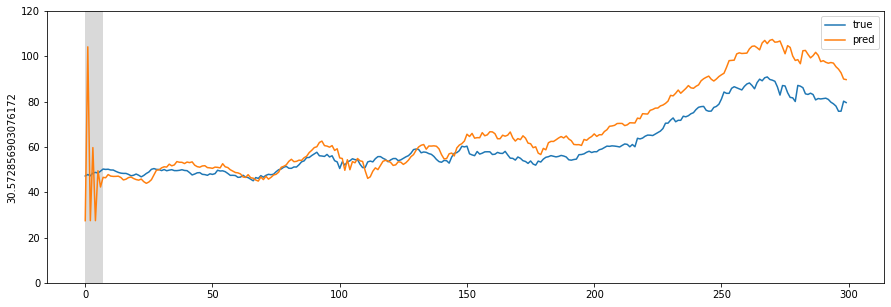

IndexError: ignored

In [ ]:
plot_comparison(start_idx=300, length=300, train=True, ylim=(0,120))

The true and predicted results are shown below, predicted price is significantly higher than true price, the accuracy of the model can be improved by trying different parameter for the model, other types of RNN models can also be considered, e.g. LSTM. 

The traditional machine learning algorithms usually use simple structure, for example, decision tree and linear regression. We also need to select the features manually of input for traditional machine learning to do the classification and give the outputs. However, deep learning is much more complex and contains multiple layers to process data. it can automatically extract features and make predictions. Additionally, deep learning algorithm can learn error of models, which can help us to improve the performance of the models. We learnt MultiLayer Perceptron Network in week4, it is consisted of input layer, output layer, and hidden layer. It can also be used to solve non-linear problems, we also can adjust parameters of each layer to improve performance of model. In week5, we use CNN models to process images. Deep learning algorithm can produce better images through encoding and decoding images, we can also adjust parameters of each layer to improve model performance. In week6, RNN model is introduced to deal with time-series data. It is able to predict future based on previous data.
In business, deep learning can be applied to improve customer experience, it can be used to understand customers’ behaviour and create recommendation system.
It also can be applied to improve quality control for companies. It can detect defects through image recognition, which can also contribute to automatic quality control processing.